In [26]:
import pandas as pd
import numpy as np
import requests
import tweepy
import json
from tweepy import OAuthHandler
from timeit import default_timer as timer
import config
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

# Part 1 Wrangling from csv data

In [3]:
twitter_archive_before = pd.read_csv('twitter-archive-enhanced.csv')

In [4]:
twitter_archive_before.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None


In [5]:
df_clean=twitter_archive_before.copy()

# Removing retweeted and reply tweet

In [6]:
df_clean=df_clean[df_clean.retweeted_status_id.isnull()]

In [7]:
df_clean=df_clean[df_clean.in_reply_to_status_id.isnull()]

# convert data type

In [8]:
df_clean.doggo=df_clean.doggo.astype('category')
df_clean.floofer=df_clean.floofer.astype('category')
df_clean.pupper=df_clean.pupper.astype('category')
df_clean.puppo=df_clean.puppo.astype('category')
df_clean.timestamp=pd.to_datetime(df_clean.timestamp)
df_clean.retweeted_status_timestamp=pd.to_datetime(df_clean.retweeted_status_timestamp)


# Merge doggo,floofer,pupper, and puppo into stage column

In [9]:
df_clean['stage'] = df_clean[['doggo', 'floofer', 'pupper', 'puppo']].max(axis=1)

In [10]:
df_clean=df_clean.drop(['doggo', 'floofer', 'pupper', 'puppo'],axis=1)

# Re-Extract rating numerator and denominator from tweet

In [11]:
df_clean['rating_numerator']=df_clean['text'].str.extract('([0-9]+[,.]?[0-9]*/)',expand=True)
df_clean['rating_numerator']=df_clean['rating_numerator'].str.replace('/','')
df_clean['rating_denominator']=df_clean['text'].str.extract('(/[0-9]+[,.]?[0-9]*)',expand=True)
df_clean['rating_denominator']=df_clean['rating_denominator'].str.replace('/','')
df_clean['rating_denominator']=df_clean['rating_denominator'].str.replace(',','')

In [12]:
df_clean['rating_numerator']=df_clean['rating_numerator'].astype('float')
df_clean['rating_denominator']=df_clean['rating_denominator'].astype('float')

# Removing non multiple of 10 from rating denominator

In [13]:
df_clean.rating_denominator.value_counts()

10.0     2080
50.0        3
80.0        2
11.0        2
150.0       1
110.0       1
90.0        1
70.0        1
170.0       1
2.0         1
120.0       1
40.0        1
20.0        1
7.0         1
Name: rating_denominator, dtype: int64

In [14]:
df_clean=df_clean[-df_clean['rating_denominator'].isin(['11.0','15.0','7.0','2.0','0.0','16.0'])]


In [15]:
df_clean.rating_denominator.value_counts()

10.0     2080
50.0        3
80.0        2
150.0       1
110.0       1
90.0        1
70.0        1
170.0       1
120.0       1
40.0        1
20.0        1
Name: rating_denominator, dtype: int64

# Removing peculiar value from rating denominator
I remove 720 and 420 from rating numerator because its value didnt represent normal rating value, it also has 10 as denominator.so it give us big rating. 

In [16]:
df_clean=df_clean[-df_clean['rating_numerator'].isin(['1776.0','420.0'])]

# Calculate Rating by diving rating numerator by rating denominator, to normalize rating for each dog (some tweet has rating denominator multiple of 10)

In [17]:
df_clean['rating']=df_clean['rating_numerator']/df_clean['rating_denominator']

# Rename a,an,such,etc to NaN

In [18]:
#rename a,an,such,quite,the,none to NaN
wrong_name=['a','an','such','quite','the','None']
for i in wrong_name:
    df_clean['name']=df_clean['name'].replace(wrong_name,np.nan)

In [19]:
df_clean.stage=df_clean.stage.replace('None',np.nan)

In [20]:
df_clean[df_clean['stage']=='None']
df_clean.stage.isnull().sum()

1755

In [21]:
df_clean.dtypes

tweet_id                               int64
in_reply_to_status_id                float64
in_reply_to_user_id                  float64
timestamp                     datetime64[ns]
source                                object
text                                  object
retweeted_status_id                  float64
retweeted_status_user_id             float64
retweeted_status_timestamp    datetime64[ns]
expanded_urls                         object
rating_numerator                     float64
rating_denominator                   float64
name                                  object
stage                                 object
rating                               float64
dtype: object

# Re-arrange colums

In [19]:
df_clean=df_clean[['tweet_id','timestamp','name','stage','rating_numerator','rating_denominator','rating','text','expanded_urls']]
df_clean

,tweet_id,timestamp,name,stage,rating_numerator,rating_denominator,rating,text,in_reply_to_status_id,in_reply_to_user_id,expanded_urls
0,892420643555336193,2017-08-01 16:23:56,Phineas,NaN,13.0,10.0,1.3,This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,https://twitter.com/dog_rates/status/892420643...
1,892177421306343426,2017-08-01 00:17:27,Tilly,NaN,13.0,10.0,1.3,This is Tilly. She's just checking pup on you....,NaN,NaN,https://twitter.com/dog_rates/status/892177421...
2,891815181378084864,2017-07-31 00:18:03,Archie,NaN,12.0,10.0,1.2,This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,https://twitter.com/dog_rates/status/891815181...
3,891689557279858688,2017-07-30 15:58:51,Darla,NaN,13.0,10.0,1.3,This is Darla. She commenced a snooze mid meal...,NaN,NaN,https://twitter.com/dog_rates/status/891689557...
4,891327558926688256,2017-07-29 16:00:24,Franklin,NaN,12.0,10.0,1.2,This is Franklin. He would like you to stop ca...,NaN,NaN,https://twitter.com/dog_rates/status/891327558...
5,891087950875897856,2017-07-29 00:08:17,NaN,NaN,13.0,10.0,1.3,Here we have a majestic great white breaching ...,NaN,NaN,https://twitter.com/dog_rates/status/891087950...
6,890971913173991426,2017-07-28 16:27:12,Jax,NaN,13.0,10.0,1.3,Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht..."
7,890729181411237888,2017-07-28 00:22:40,NaN,NaN,13.0,10.0,1.3,When you watch your owner call another dog a g...,NaN,NaN,https://twitter.com/dog_rates/status/890729181...
8,890609185150312448,2017-07-27 16:25:51,Zoey,NaN,13.0,10.0,1.3,This is Zoey. She doesn't want to be one of th...,NaN,NaN,https://twitter.com/dog_rates/status/890609185...
9,890240255349198849,2017-07-26 15:59:51,Cassie,doggo,14.0,10.0,1.4,This is Cassie. She is a college pup. Studying...,NaN,NaN,https://twitter.com/dog_rates/status/890240255...


# Part 2 Gathering image-prediction.tsv

In [20]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)

In [21]:
 with open ("image_prediction.tsv",mode='wb') as file:
    file.write(response.content)

In [22]:
image_prediction = pd.read_csv('image_prediction.tsv',sep='\t')
image_prediction.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [23]:
image_prediction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [24]:
twitter_archived  = pd.merge(df_clean, image_prediction, on=['tweet_id'], how='left')

In [25]:
twitter_archived.head()

,tweet_id,timestamp,name,stage,rating_numerator,rating_denominator,rating,text,in_reply_to_status_id,in_reply_to_user_id,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,2017-08-01 16:23:56,Phineas,NaN,13.0,10.0,1.3,This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,...,1.0,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,892177421306343426,2017-08-01 00:17:27,Tilly,NaN,13.0,10.0,1.3,This is Tilly. She's just checking pup on you....,NaN,NaN,...,1.0,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2,891815181378084864,2017-07-31 00:18:03,Archie,NaN,12.0,10.0,1.2,This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,...,1.0,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
3,891689557279858688,2017-07-30 15:58:51,Darla,NaN,13.0,10.0,1.3,This is Darla. She commenced a snooze mid meal...,NaN,NaN,...,1.0,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
4,891327558926688256,2017-07-29 16:00:24,Franklin,NaN,12.0,10.0,1.2,This is Franklin. He would like you to stop ca...,NaN,NaN,...,2.0,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True


# Part 3 Gathering data from twitter

In [26]:
consumer_key = config.consumer_key
consumer_secret = config.consumer_secret
access_token = config.access_token
access_secret = config.access_secret

In [27]:
tweet_id = df_clean['tweet_id'].values.tolist()

In [28]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth,wait_on_rate_limit=True)

tweet_id = df_clean['tweet_id'].values.tolist()

In [29]:
# NOTE TO STUDENT WITH MOBILE VERIFICATION ISSUES:
# df_1 is a DataFrame with the twitter_archive_enhanced.csv file. You may have to
# change line 17 to match the name of your DataFrame with twitter_archive_enhanced.csv
# NOTE TO REVIEWER: this student had mobile verification issues so the following
# Twitter API code was sent to this student from a Udacity instructor
# Tweet IDs for which to gather additional data via Twitter's API
tweet_ids = df_clean.tweet_id.values
len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print(e)
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)


1: 892420643555336193
Success
2: 892177421306343426
Success
3: 891815181378084864
Success
4: 891689557279858688
Success
5: 891327558926688256
Success
6: 891087950875897856
Success
7: 890971913173991426
Success
8: 890729181411237888
Success
9: 890609185150312448
Success
10: 890240255349198849
Success
11: 890006608113172480
Success
12: 889880896479866881
Success
13: 889665388333682689
Success
14: 889638837579907072
Success
15: 889531135344209921
Success
16: 889278841981685760
Success
17: 888917238123831296
Success
18: 888804989199671297
Success
19: 888554962724278272
Success
20: 888078434458587136
Success
21: 887705289381826560
Success
22: 887517139158093824
Success
23: 887473957103951883
Success
24: 887343217045368832
Success
25: 887101392804085760
Success
26: 886983233522544640
Success
27: 886736880519319552
Success
28: 886680336477933568
Success
29: 886366144734445568
Success
30: 886267009285017600
Success
31: 886258384151887873
Success
32: 885984800019947520
Success
33: 8855289432054

Success
261: 835574547218894849
Success
262: 835297930240217089
Success
263: 835264098648616962
Success
264: 835172783151792128
Success
265: 835152434251116546
Success
266: 834931633769889797
Success
267: 834786237630337024
Success
268: 834574053763584002
Success
269: 834458053273591808
Success
270: 834209720923721728
Success
271: 834167344700198914
Success
272: 834089966724603904
Success
273: 834086379323871233
Success
274: 833863086058651648
Success
275: 833826103416520705
Success
276: 833722901757046785
Success
277: 833479644947025920
Success
278: 833124694597443584
Success
279: 832998151111966721
Success
280: 832757312314028032
Success
281: 832682457690300417
Success
282: 832645525019123713
Success
283: 832636094638288896
Success
284: 832397543355072512
Success
285: 832369877331693569
Success
286: 832273440279240704
Success
287: 832032802820481025
Success
288: 831939777352105988
Success
289: 831926988323639298
Success
290: 831911600680497154
Success
291: 831670449226514432
Success


Success
518: 793165685325201412
Success
519: 793150605191548928
Success
520: 793135492858580992
Success
521: 793120401413079041
Success
522: 792913359805018113
Success
523: 792883833364439040
Success
524: 792773781206999040
Success
525: 792394556390137856
Success
526: 792050063153438720
Success
527: 791774931465953280
Success
528: 791672322847637504
Success
529: 791406955684368384
Success
530: 791312159183634433
Success
531: 790987426131050500
Success
532: 790946055508652032
Success
533: 790698755171364864
Success
534: 790581949425475584
Success
535: 790337589677002753
Success
536: 790277117346975746
Success
537: 789986466051088384
Success
538: 789903600034189313
Success
539: 789628658055020548
Success
540: 789599242079838210
Success
541: 789530877013393408
Success
542: 789314372632018944
Success
543: 789268448748703744
Success
544: 789137962068021249
Success
545: 788908386943430656
Success
546: 788765914992902144
Success
547: 788412144018661376
Success
548: 788178268662984705
Success


Success
773: 752173152931807232
Success
774: 751950017322246144
Success
775: 751937170840121344
Success
776: 751830394383790080
Success
777: 751793661361422336
Success
778: 751598357617971201
Success
779: 751583847268179968
Success
780: 751538714308972544
Success
781: 751456908746354688
Success
782: 751251247299190784
Success
783: 751205363882532864
Success
784: 751132876104687617
Success
785: 750868782890057730
Success
786: 750719632563142656
Success
787: 750506206503038976
Success
788: 750429297815552001
Success
789: 750383411068534784
Success
790: 750381685133418496
Success
791: 750147208377409536
Success
792: 750132105863102464
Success
793: 750117059602808832
Success
794: 750101899009982464
Success
795: 750086836815486976
Success
796: 750071704093859840
Success
797: 750056684286914561
Success
798: 750041628174217216
Success
799: 750026558547456000
Success
800: 750011400160841729
Success
801: 749996283729883136
Success
802: 749981277374128128
Success
803: 749774190421639168
Success


Success
1026: 715733265223708672
Success
1027: 715704790270025728
Success
1028: 715696743237730304
Success
1029: 715680795826982913
Success
1030: 715360349751484417
Success
1031: 715342466308784130
Success
1032: 715220193576927233
Success
1033: 715200624753819648
Success
1034: 715009755312439296
Success
1035: 714982300363173890
Success
1036: 714962719905021952
Success
1037: 714957620017307648
Success
1038: 714631576617938945
Success
1039: 714606013974974464
Success
1040: 714485234495041536
Success
1041: 714258258790387713
Success
1042: 714251586676113411
Success
1043: 714214115368108032
Success
1044: 714141408463036416
Success
1045: 713919462244790272
Success
1046: 713909862279876608
Success
1047: 713900603437621249
Success
1048: 713761197720473600
Success
1049: 713411074226274305
Success
1050: 713177543487135744
Success
1051: 713175907180089344
Success
1052: 712809025985978368
Success
1053: 712717840512598017
Success
1054: 712668654853337088
Success
1055: 712438159032893441
Success
10

Success
1275: 695095422348574720
Success
1276: 695074328191332352
Success
1277: 695064344191721472
Success
1278: 695051054296211456
Success
1279: 694925794720792577
Success
1280: 694905863685980160
Success
1281: 694669722378485760
Success
1282: 694356675654983680
Success
1283: 694352839993344000
Success
1284: 694342028726001664
Success
1285: 694329668942569472
Success
1286: 694206574471057408
Success
1287: 694183373896572928
Success
1288: 694001791655137281
Success
1289: 693993230313091072
Success
1290: 693942351086120961
Success
1291: 693647888581312512
Success
1292: 693644216740769793
Success
1293: 693642232151285760
Success
1294: 693629975228977152
Success
1295: 693622659251335168
Success
1296: 693590843962331137
Success
1297: 693582294167244802
Success
1298: 693486665285931008
Success
1299: 693280720173801472
Success
1300: 693267061318012928
Success
1301: 693262851218264065
Success
1302: 693231807727280129
Success
1303: 693155686491000832
Success
1304: 693109034023534592
Success
13

Success
1524: 680798457301471234
Success
1525: 680609293079592961
Success
1526: 680583894916304897
Success
1527: 680497766108381184
Success
1528: 680494726643068929
Success
1529: 680473011644985345
Success
1530: 680440374763077632
Success
1531: 680221482581123072
Success
1532: 680206703334408192
Success
1533: 680191257256136705
Success
1534: 680176173301628928
Success
1535: 680161097740095489
Success
1536: 680145970311643136
Success
1537: 680130881361686529
Success
1538: 680115823365742593
Success
1539: 680100725817409536
Success
1540: 680085611152338944
Success
1541: 680070545539371008
Success
1542: 680055455951884288
[{'code': 144, 'message': 'No status found with that ID.'}]
1543: 679877062409191424
Success
1544: 679872969355714560
Success
1545: 679862121895714818
Success
1546: 679854723806179328
Success
1547: 679844490799091713
Success
1548: 679828447187857408
Success
1549: 679777920601223168
Success
1550: 679736210798047232
Success
1551: 679729593985699840
Success
1552: 6797220165

Success
1771: 673636718965334016
Success
1772: 673612854080196609
Success
1773: 673583129559498752
Success
1774: 673580926094458881
Success
1775: 673576835670777856
Success
1776: 673363615379013632
Success
1777: 673359818736984064
Success
1778: 673355879178194945
Success
1779: 673352124999274496
Success
1780: 673350198937153538
Success
1781: 673345638550134785
Success
1782: 673343217010679808
Success
1783: 673342308415348736
Success
1784: 673320132811366400
Success
1785: 673317986296586240
Success
1786: 673295268553605120
Success
1787: 673270968295534593
Success
1788: 673240798075449344
Success
1789: 673213039743795200
Success
1790: 673148804208660480
Success
1791: 672997845381865473
Success
1792: 672995267319328768
Success
1793: 672988786805112832
Success
1794: 672984142909456390
Success
1795: 672980819271634944
Success
1796: 672975131468300288
Success
1797: 672970152493887488
Success
1798: 672968025906282496
Success
1799: 672964561327235073
Success
1800: 672902681409806336
Success
18

Success
2017: 668645506898350081
Success
2018: 668643542311546881
Success
2019: 668641109086707712
Success
2020: 668636665813057536
Success
2021: 668633411083464705
Success
2022: 668631377374486528
Success
2023: 668627278264475648
Success
2024: 668625577880875008
Success
2025: 668623201287675904
Success
2026: 668620235289837568
Success
2027: 668614819948453888
Success
2028: 668587383441514497
Success
2029: 668567822092664832
Success
2030: 668544745690562560
Success
2031: 668542336805281792
Success
2032: 668537837512433665
Success
2033: 668528771708952576
Success
2034: 668507509523615744
Success
2035: 668496999348633600
Success
2036: 668484198282485761
Success
2037: 668480044826800133
Success
2038: 668466899341221888
Success
2039: 668297328638447616
Success
2040: 668291999406125056
Success
2041: 668286279830867968
Success
2042: 668274247790391296
Success
2043: 668268907921326080
Success
2044: 668256321989451776
Success
2045: 668248472370458624
Success
2046: 668237644992782336
Success
20

# Reading json data

In [30]:
with open('tweet_json.txt') as f:
    data = json.loads("[" + 
        f.read().replace("}\n{", "},\n{") + 
    "]")


In [31]:
data=pd.DataFrame(data)

In [32]:
data.dtypes

contributors                      object
coordinates                       object
created_at                        object
display_text_range                object
entities                          object
extended_entities                 object
favorite_count                     int64
favorited                           bool
full_text                         object
geo                               object
id                                 int64
id_str                            object
in_reply_to_screen_name           object
in_reply_to_status_id            float64
in_reply_to_status_id_str         object
in_reply_to_user_id              float64
in_reply_to_user_id_str           object
is_quote_status                     bool
lang                              object
place                             object
possibly_sensitive                object
possibly_sensitive_appealable     object
quoted_status                     object
quoted_status_id                 float64
quoted_status_id

In [33]:
addtional_data=data[['id','retweet_count','favorite_count']]
addtional_data=addtional_data.rename(index=str, columns={"id": "tweet_id"})
addtional_data

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8320,38029
1,892177421306343426,6144,32656
2,891815181378084864,4068,24581
3,891689557279858688,8454,41383
4,891327558926688256,9162,39569
5,891087950875897856,3046,19870
6,890971913173991426,2019,11615
7,890729181411237888,18455,64194
8,890609185150312448,4188,27304
9,890240255349198849,7215,31312


In [34]:
twitter_archived.shape

(2168, 22)

In [35]:
addtional_data.shape

(2164, 3)

# Part 4 Merge additional data such as retweeted_count and favourite_count into twitter_archived dataframe

In [36]:
twitter_archived_final  = pd.merge(twitter_archived, addtional_data, on=['tweet_id'], how='left')

In [37]:
twitter_archived_final.head()

,tweet_id,timestamp,name,stage,rating_numerator,rating_denominator,rating,text,in_reply_to_status_id,in_reply_to_user_id,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count
0,892420643555336193,2017-08-01 16:23:56,Phineas,NaN,13.0,10.0,1.3,This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,...,0.097049,False,bagel,0.085851,False,banana,0.076110,False,8320.0,38029.0
1,892177421306343426,2017-08-01 00:17:27,Tilly,NaN,13.0,10.0,1.3,This is Tilly. She's just checking pup on you....,NaN,NaN,...,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,6144.0,32656.0
2,891815181378084864,2017-07-31 00:18:03,Archie,NaN,12.0,10.0,1.2,This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,...,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,4068.0,24581.0
3,891689557279858688,2017-07-30 15:58:51,Darla,NaN,13.0,10.0,1.3,This is Darla. She commenced a snooze mid meal...,NaN,NaN,...,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,8454.0,41383.0
4,891327558926688256,2017-07-29 16:00:24,Franklin,NaN,12.0,10.0,1.2,This is Franklin. He would like you to stop ca...,NaN,NaN,...,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,9162.0,39569.0


# Storing Cleaned DataFrame into csv file

In [38]:
twitter_archived_final.to_csv('twitter_archive_master.csv', sep=',', encoding='utf-8')


# Before and After

In [46]:
twitter_archive_before.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [62]:
df_clean.rating_denominator.value_counts()

10.0     2153
50.0        3
80.0        2
20.0        2
150.0       1
110.0       1
90.0        1
130.0       1
70.0        1
170.0       1
120.0       1
40.0        1
Name: rating_denominator, dtype: int64

In [130]:
twitter_archive_before.rating_numerator.value_counts();

In [132]:
twitter_archive_before['rating']=twitter_archive_before['rating_numerator']/twitter_archive_before['rating_numerator']

Text(0.5,1,'Rating Histogram')

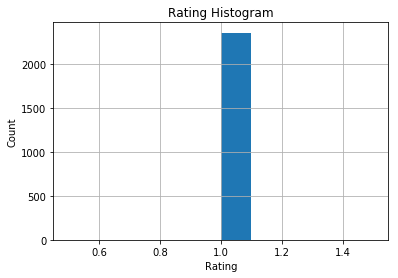

In [147]:
twitter_archive_before.rating.hist()
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Rating Histogram')

In [156]:
twitter_archive_before.rating.value_counts()

1.0    2354
Name: rating, dtype: int64

In [ ]:
df_clean.rating.value_counts()

Text(0.5,1,'Rating Histogram')

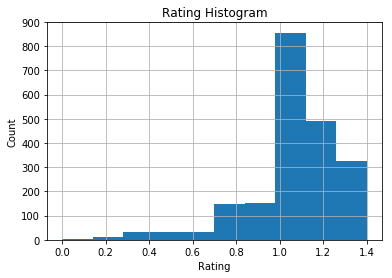

In [154]:
df_clean.rating.hist()
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Rating Histogram')

In [ ]:
twitter_archive_before.retweeted_status_id.count()

In [22]:
df_clean.stage.value_counts()

pupper     230
doggo       72
puppo       24
floofer     10
Name: stage, dtype: int64

Text(0.5,1,'Dog Stage')

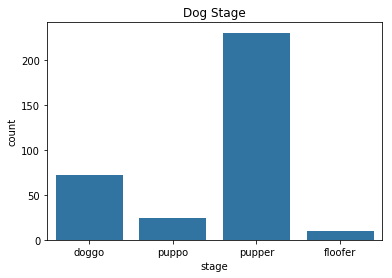

In [29]:
base_color=sb.color_palette()[0]
sb.countplot(data=df_clean,x='stage',color=base_color)
plt.title('Dog Stage')

In [35]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2091 entries, 0 to 2355
Data columns (total 15 columns):
tweet_id                      2091 non-null int64
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     2091 non-null datetime64[ns]
source                        2091 non-null object
text                          2091 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null datetime64[ns]
expanded_urls                 2088 non-null object
rating_numerator              2091 non-null float64
rating_denominator            2091 non-null float64
name                          1418 non-null object
stage                         336 non-null object
rating                        2091 non-null float64
dtypes: datetime64[ns](2), float64(7), int64(1), object(5)
memory usage: 341.4+ KB
